<h3>Applied Machine Learning and Optimisation</h3>
<h3>Assignment 2</h3>

<h4>Group</h4>
<ul>
    <li>Mikhail Mironov u211361</li>
    <li>Mikhail Martyanov u211360</li>
    <li>Sofya Tarasova u211359</li>
</ul>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import *
from tqdm import tqdm

In [2]:
# load data 
demand_events = pd.read_csv('demand_events.csv')
sourcing_events = pd.read_csv('sourcing_events.csv')
stock_state = pd.read_csv('stock_state.csv')

In [3]:
# convert dtypes to dates 
demand_events["date"] = pd.to_datetime(demand_events["date"])

sourcing_events["request_date"] = pd.to_datetime(sourcing_events["request_date"])
sourcing_events["delivery_date"] = pd.to_datetime(sourcing_events["delivery_date"])

stock_state["date"] = pd.to_datetime(stock_state["date"])

In [4]:
demand_events.shape

(365, 2)

<h3>Task 1</h3>

<p>Elisa wants you to measure the performance of the last year, providing
quantitative metrics. She knows it was a bad year, but hasn't looked at the real
data to summarize how bad it was. Remember that there is a trade-off: too
much stock, is not desired, but running out of stock and making clients wait is
also negative.</p>
<p>– Going one step further, Elisa wants to know: what was done wrong?</p>

$stock_{i} = stock_{i-1} - demand_{i} + supply_{i}$

In [5]:
demand_events.head(3)

date  demand_quantity
0 2021-01-01     54609.492813
1 2021-01-02     36208.636486
2 2021-01-03     77784.172768

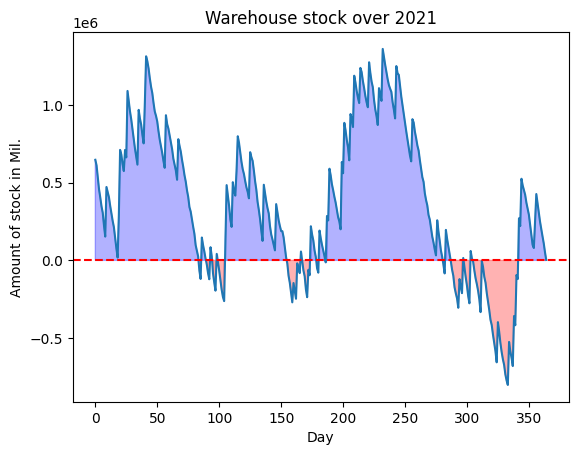

In [85]:
fig, ax = plt.subplots()

ax.plot(stock_state["amount_in_stock"])

plt.title("Warehouse stock over 2021")
ax.axhline(y=0, color="red", linestyle="--")

x = stock_state.index
y = stock_state["amount_in_stock"].values

plt.fill_between(
    x, y, 0, where=(y >= 0), color='blue', alpha=0.3
)

plt.fill_between(
    x, y, 0, where=(y <= 0), color='red', alpha=0.3
)

plt.xlabel("Day")
plt.ylabel("Amount of stock in Mil.")
plt.savefig("intro.png", bbox_inches="tight")
plt.show()

In [117]:
pd.concat([
    stock_state["amount_in_stock"].describe().to_frame(),
    demand_events["demand_quantity"].describe().to_frame(),
    sourcing_events["LT"].describe()
], axis=1).round(3)

amount_in_stock  demand_quantity      LT
count          365.000          365.000  60.000
mean        359941.218        50149.196   7.317
std         475980.653        14220.766   1.846
min        -802079.121         1380.990   4.000
25%          11902.539        40200.062   6.000
50%         313724.586        50873.131   7.000
75%         720190.548        59385.010   9.000
max        1361247.271       107790.972  12.000

In [44]:
def auc(x, y):
    y_adjusted = np.maximum(y, 0)  # Adjust negative values to zero
    total_area = np.trapz(y_adjusted, x)
    
    y_negative = np.minimum(y, 0)  # Identify negative values
    area_below_zero = np.trapz(y_negative, x)  # Calculate area below zero
    
    area_subtracted = total_area - area_below_zero  # Subtract area below zero from total area
    return area_subtracted

In [47]:
auc(x=stock_state["amount_in_stock"].index, y=stock_state["amount_in_stock"].values)

172916558.9841376

<AxesSubplot: >

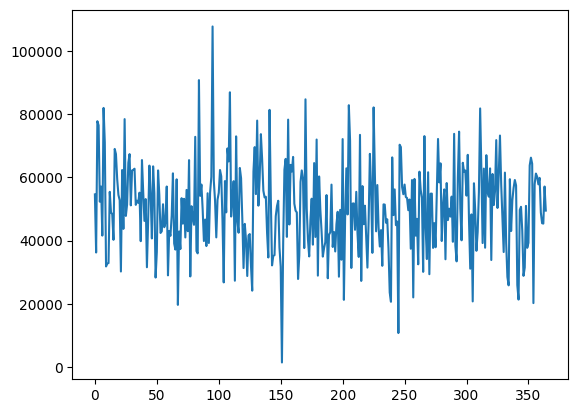

In [8]:
daily_demand = demand_events.groupby("date")["demand_quantity"].sum().to_frame()
daily_demand["date"] = daily_demand.index
daily_demand = daily_demand.reset_index(drop=True)
daily_demand["demand_quantity"].plot()

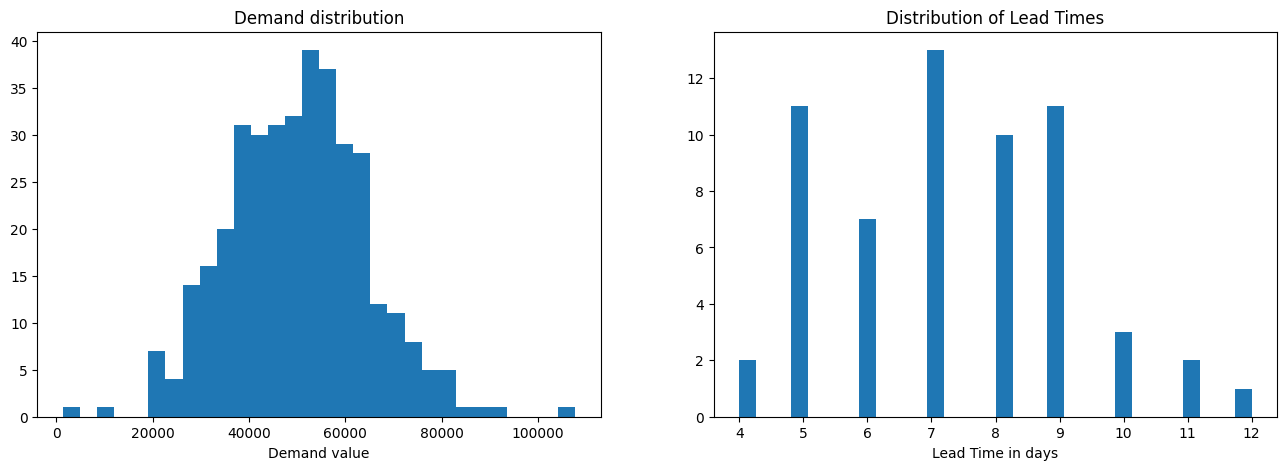

In [100]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax1, ax2 = axs

ax1.hist(daily_demand["demand_quantity"], bins=30)
ax1.set_title("Demand distribution")
ax1.set_xlabel("Demand value")

ax2.hist(sourcing_events["LT"], bins=30)
ax2.set_title("Distribution of Lead Times")
ax2.set_xlabel("Lead Time in days")

plt.savefig("distrs.png", bbox_inches="tight")
plt.show()

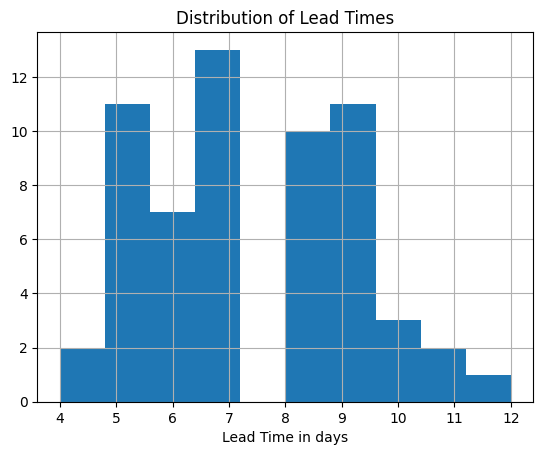

In [95]:
sourcing_events["LT"].hist()
plt.title("Distribution of Lead Times")
plt.xlabel("Lead Time in days")

plt.savefig("leadtimes_distr.png", bbox_inches="tight")
plt.show()

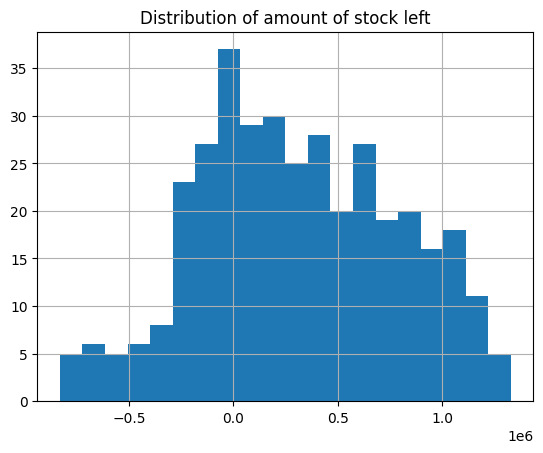

In [9]:
df_ds = daily_demand.merge(stock_state, on="date", how="inner")
df_ds["stock_left"] = df_ds["amount_in_stock"] - df_ds["demand_quantity"]
df_ds["stock_left"].hist(bins=20)

plt.title("Distribution of amount of stock left")
plt.show()

<h4>Calculating Total costs</h4>

In [10]:
# define very importance hyperparams
S = 1000000 # reordering cost (one time fixed cost)
H = 1 # daily holding cost per unit
B = 100

In [11]:
total_cost_pr = 0

# add holding inventory costs and backorder costs
for el in df_ds["stock_left"]:
    total_cost_pr += abs(el) * H if el >= 0 else abs(el) * B

# add to that reordering costs (resupplies always include costs like transportation and etc)
total_cost_pr += sourcing_events.shape[0] * S

print(f"Total Cost for previous strategy: {round(total_cost_pr, 3)}")

Total Cost for previous strategy: 2798219999.983


<h3>Task 2</h3>

<p>Elisa wants you to propose an ordering policy. This means, that you need to
define a rule that, once each day, should answer the questions: should we place
a Purchase Order to request beans from Diemen today? If yes, how much
should we order?</p>

<p>We will use <b>Periodic review model</b> that also takes into account reordering cost and cost of holding stock in inventory. This model will tell us optimal number of days when to check the stock along with Maximum Quantity held at inventory at one time. Each time we reorder we should refill supply so it is this Maximum Quantity</p>

<h4>Periodic review model</h4>

$TC = D\cdot C + \frac{D}{Q} \cdot S + \frac{Q}{2} \cdot H \rightarrow min$

<p>As a result of minimisation we get the following optimal order quantity $Q^*$</p>
<br>
$Q^* = \sqrt{\frac{2D\cdot S}{H}}$ - optimal quantity to reorder at one time
<br>
$T^* = \frac{Q^*}{D}$ - review time 
<br>
$M^* = D \cdot (T^*+LT) + z_{\alpha} \sqrt{(T^*+LT)\cdot \sigma_{d}^2 + D \cdot \sigma_{LT}^2}$ - maximum anount of stock

Since 95% level is desired $z_{0.95}$ = 1.6449
<br>
<p>Now we will backtest this strategy with simulation. Expected values and deviations for demand as well as LT will be taken from previous historic data</p>

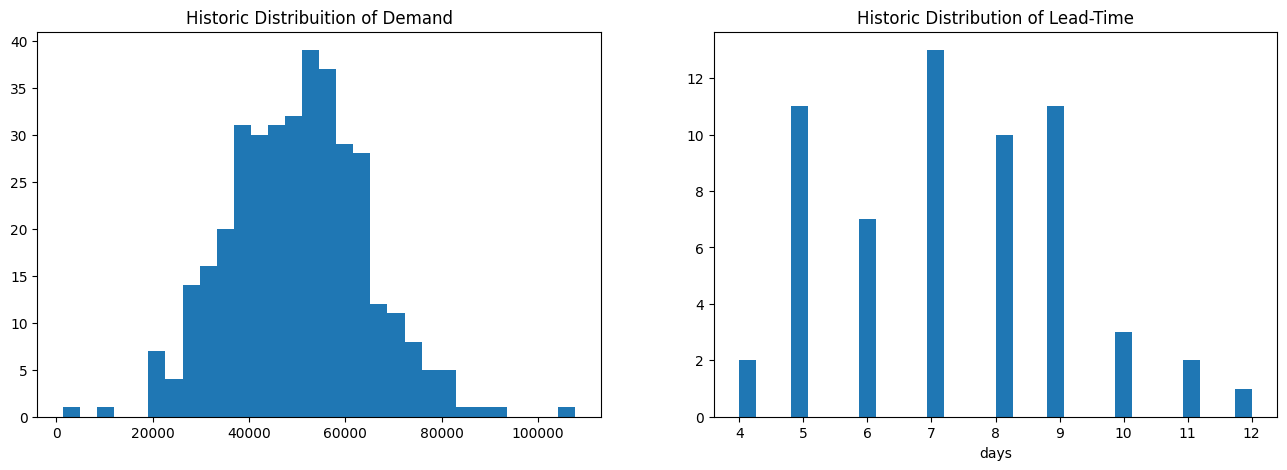

In [12]:
# get historical values for mean and std for both demand and lead-time
sourcing_events["LT"] = (sourcing_events["delivery_date"] - sourcing_events["request_date"]).dt.days 

fig, axs = plt.subplots(1, 2, figsize=(16, 5))
ax1, ax2 = axs

ax1.hist(daily_demand["demand_quantity"], bins=30)
ax1.set_title("Historic Distribuition of Demand")

ax2.hist(sourcing_events["LT"], bins=30)
ax2.set_title("Historic Distribution of Lead-Time")
ax2.set_xlabel("days")

plt.show()

In [13]:
LT_mean, LT_std = sourcing_events["LT"].mean(), sourcing_events["LT"].std()
D_mean, D_std = daily_demand["demand_quantity"].mean(), daily_demand["demand_quantity"].std()

pd.DataFrame({
    "Mean": [LT_mean, D_mean],
    "Std": [LT_std, D_std]
})

Mean           Std
0      7.316667      1.845670
1  50149.196033  14220.766342

<p>We get following distributions of demand and lead-time<p>
$D \sim{N(50149.2, 14220.76^{2})}$ <br>
$LT \sim{N(7.317, 1.846)}$

In [14]:
from math import ceil

In [15]:
Q = np.sqrt((2*D_mean*S)/ H)
T = Q / D_mean

SS = 1.6449 * np.sqrt((T + LT_mean)*D_std**2 + LT_std**2*D_mean)

M = D_mean*(T + LT_mean) + SS

T, M = ceil(T), ceil(M)
T, M

(7, 769993)

In [16]:
# test the model with sampling demands and LTs from historic data
def run_eoq_model(
    demands: np.array,
    T: int,
    M: int,
    on_hand: int,
) -> Dict[str, Any]:
    
    n_days = len(demands)
    stock = np.zeros(n_days) # sample demand values for each day from historic distribution
    
    data = {
        "reorders": np.zeros(n_days),
        "lead_times": np.full((n_days,), np.nan),
        "n_reorders": 0
    }
    
    stock[0] = on_hand
    
    for i in range(n_days-1):
        
        stock[i] -= demands[i]
        
        # check the inventory after T* days
        if i % T == 0:
            # if inventory is greater that M dont order anything
            reorder = max(M - stock[i], 0) # reorder the amount necessary to get back to M
            
            if reorder > 0:
                
                data["reorders"][i] = reorder
                data["n_reorders"] += 1

                days_until_arrival = ceil(np.random.normal(LT_mean, LT_std))

                data["lead_times"][i] = days_until_arrival

                # increment inventory to the day when resupply arrives
                if (i + days_until_arrival) <= (n_days - 1):
                    stock[i + days_until_arrival] += reorder
                              
        stock[i+1] += stock[i]
    
    data["stock"] = stock
    data["demands"] = demands
    
    return data

In [17]:
historic_demands = demand_events["demand_quantity"].values

res = run_eoq_model(
    demands=historic_demands, T=T, M=M, on_hand=stock_state.iloc[0, -1]
)

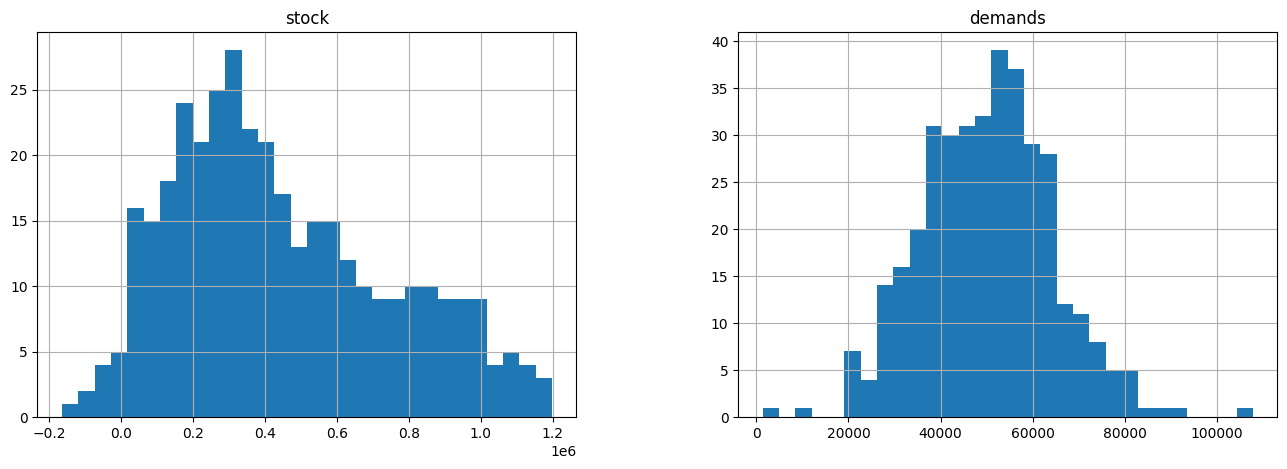

In [18]:
df_eoq = pd.DataFrame(res)

df_eoq[["stock", "demands"]].hist(figsize=(16, 5), bins=30)


plt.show()

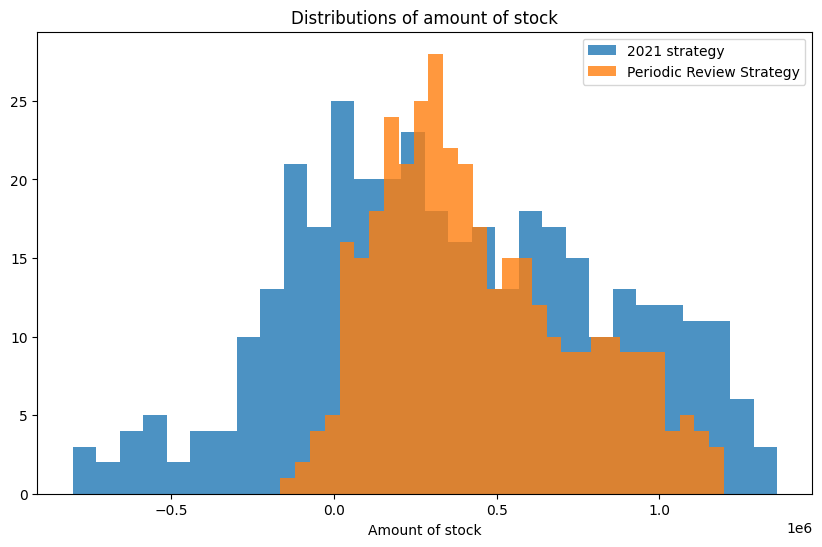

In [136]:
plt.figure(figsize=(10, 6))

plt.hist(stock_state["amount_in_stock"], bins=30, alpha=0.8, label="2021 strategy")
plt.hist(df_eoq["stock"], bins=30, alpha=0.8, label="Periodic Review Strategy")

plt.title("Distributions of amount of stock")
plt.xlabel("Amount of stock")
plt.legend()

plt.savefig("comparison_distrs", bbox_inches="tight")
plt.show()

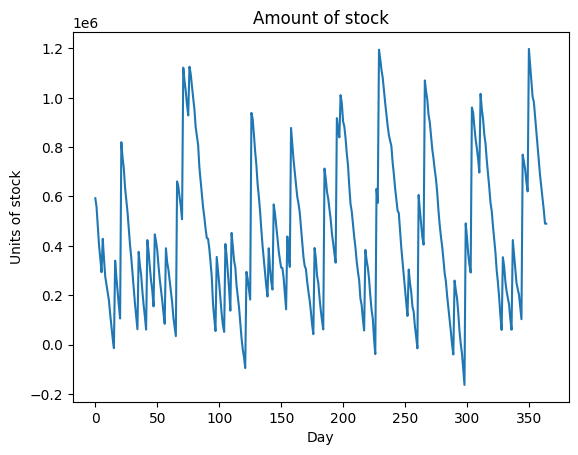

In [132]:
plt.plot(df_eoq["stock"])
plt.title("Amount of stock")
plt.xlabel("Day")
plt.ylabel("Units of stock")

plt.savefig("proposed_stock.png", bbox_inches="tight")
plt.show()

In [48]:
auc(x=df_eoq["stock"].index, y=df_eoq["stock"].values)

163258703.38947055

In [20]:
def calc_total_cost(res) -> float:
    total_cost = 0

    # add holding inventory costs and backorder costs
    for el in res["stock"]:
        total_cost += abs(el) * H if el >= 0 else abs(el) * B
    # add to that reordering costs (resupplies always include costs like transportation and etc)
    total_cost += res["n_reorders"] * S
    
    return total_cost

In [21]:
total_costs: List[float] = []
service_level: List[float] = []

for _ in tqdm(range(10000)):
    res = run_eoq_model(
        demands=historic_demands, T=T, M=M, on_hand=stock_state.iloc[0, -1]
    )
    total_costs.append(calc_total_cost(res))
    service_level.append(
        (res["stock"] > 0).sum() / res["stock"].shape[0] # probability of stockout
    )

df_eoq_hist = pd.DataFrame({
    "costs_suggested": total_costs,
    "service_levels": service_level
})

100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1079.58it/s]


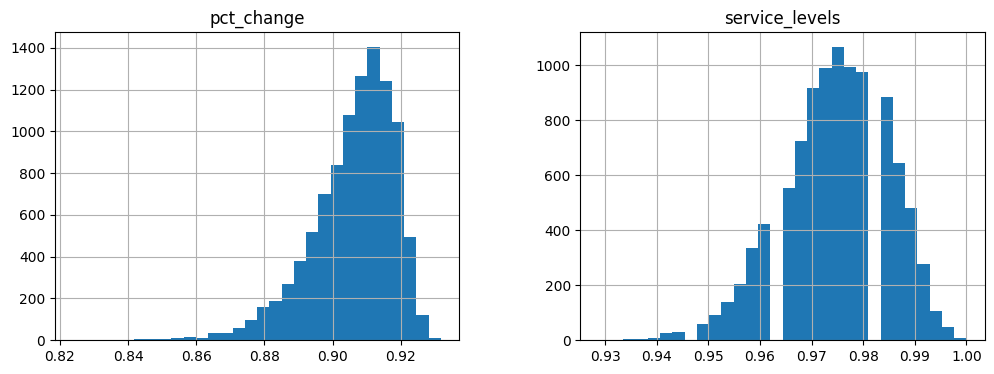

In [150]:
df_eoq_hist["pct_change"] = (total_cost_pr - df_eoq_hist["costs_suggested"]) / (total_cost_pr)

df_eoq_hist[["pct_change", "service_levels"]].hist(figsize=(12, 4), bins=30)

plt.savefig("cost_res_1.png", bbox_inches="tight")
plt.show()

<h4>Run on both sampled prices and sampled lead times</h4>

In [23]:
total_costs: List[float] = []
service_level: List[float] = []

for _ in tqdm(range(10000)):
    
    res = run_eoq_model(
        demands=np.random.normal(D_mean, D_std, 1000), 
        T=T, M=M, 
        on_hand=stock_state.iloc[0, -1]
    )
    
    total_costs.append(calc_total_cost(res))
    service_level.append(
        (res["stock"] > 0).sum() / res["stock"].shape[0] # probability of stockout
    )

df_eoq_sim = pd.DataFrame({
    "costs_suggested": total_costs,
    "service_levels": service_level
})

100%|████████████████████████████████████| 10000/10000 [00:28<00:00, 354.07it/s]


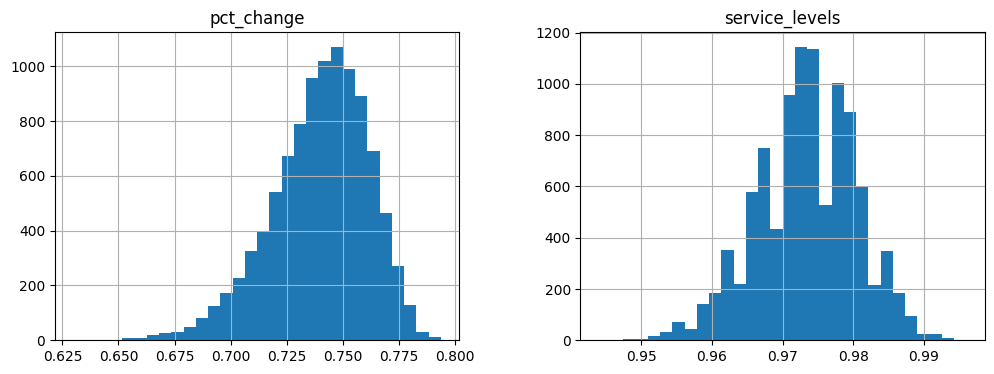

In [152]:
df_eoq_sim["pct_change"] = (total_cost_pr - df_eoq_sim["costs_suggested"]) / (total_cost_pr)

df_eoq_sim[["pct_change", "service_levels"]].hist(figsize=(12, 4), bins=30)
plt.savefig("cost_res_1.png", bbox_inches="tight")
plt.show()

<h3>Task 3</h3>
<p>Right after you finished designing your policy for level 2, Elisa called with some
news: she has just been informed by the management in Diemen that a new
Minimum Order Quantity (MOQ) rule will begin soon. This rule means that,
when the Caserta warehouse places an order to request material from Diemen,
the order should be of at least 500,000 kgs of beans, and not less than that.
– Elisa wants you to take this into account. Does it affect the policy you proposed
for level 2? If so, you need to come up with a new one that adapts to this rule
and compare it to the previous one.</p>

In [25]:
print(f"Previously optinal quantity to order {Q}")

Previously optinal quantity to order 316699.21387076686


In [26]:
T = Q / D_mean

SS = 1.6449 * np.sqrt((T + LT_mean)*D_std**2 + LT_std**2*D_mean) # safety stock

M = D_mean*(T + LT_mean) + SS

T, M = ceil(T), ceil(M)
T, M

(7, 769993)

In [27]:
# slightly different version updates with a condition that we can't buy less than 500000
def run_min_eoq_model(demands: np.array, T: int, M: int, on_hand: int) -> Dict[str, Any]:
    
    n_days = len(demands)
    stock = np.zeros(n_days) # sample demand values for each day from historic distribution
    
    data = {
        "reorders": np.zeros(n_days),
        "lead_times": np.full((n_days,), np.nan),
        "n_reorders": 0
    }
    
    stock[0] = on_hand
    
    try_next_day = False
    
    for i in range(n_days-1):
    
        stock[i] -= demands[i]
        # check the inventory after T* days
        if (i % T == 0) or try_next_day:
            
            # if inventory is greater that M dont order anything
            reorder = max(M - stock[i], 0) # reorder the amount necessary to get back to M
            # previously this would trigger the new order but now we have to wait until we have 500000
            if reorder > 0 and reorder < 500000:
                try_next_day = True
                
            if reorder >= 500000:
                try_next_day = False
                data["reorders"][i] = reorder
                data["n_reorders"] += 1

                days_until_arrival = ceil(np.random.normal(LT_mean, LT_std))
                data["lead_times"][i] = days_until_arrival

                # increment inventory to the day when resupply arrives
                if (i + days_until_arrival) <= (n_days - 1):
                    stock[i + days_until_arrival] += reorder
                     
        stock[i+1] += stock[i]
    
    data["stock"] = stock
    data["demands"] = demands
    
    return data

<h4>New model on historic data</h4>

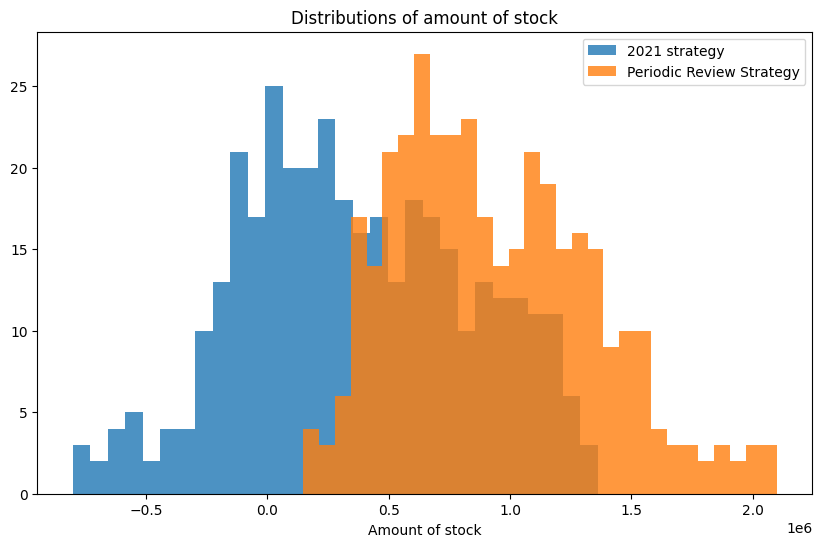

In [139]:
res = run_min_eoq_model(
    demands=historic_demands, T=T, M=M, on_hand=stock_state.iloc[0, -1]
)

df_eoq = pd.DataFrame(res)

plt.figure(figsize=(10, 6))

plt.hist(stock_state["amount_in_stock"], bins=30, alpha=0.8, label="2021 strategy")
plt.hist(df_eoq["stock"], bins=30, alpha=0.8, label="Periodic Review Strategy")

plt.title("Distributions of amount of stock")
plt.xlabel("Amount of stock")
plt.legend()

plt.savefig("comparison_distrs_2.png", bbox_inches="tight")
plt.show()

In [28]:
total_costs: List[float] = []
service_level: List[float] = []

for _ in tqdm(range(10000)):
    res = run_min_eoq_model(
        demands=historic_demands, T=T, M=M, on_hand=stock_state.iloc[0, -1]
    )
    total_costs.append(calc_total_cost(res))
    service_level.append(
        (res["stock"] > 0).sum() / res["stock"].shape[0] # probability of stockout
    )

df_min_eoq_hist = pd.DataFrame({
    "costs_suggested": total_costs,
    "service_levels": service_level
})

100%|████████████████████████████████████| 10000/10000 [00:12<00:00, 787.44it/s]


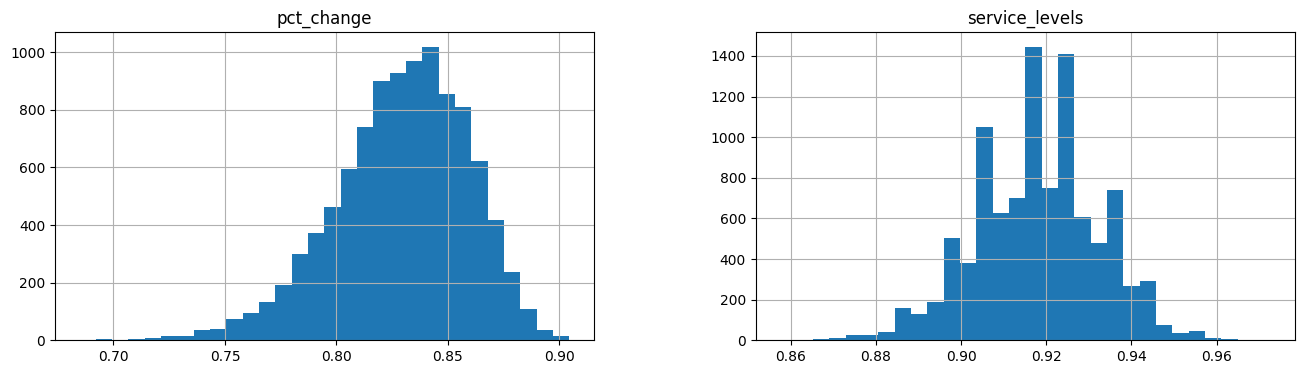

In [29]:
df_min_eoq_hist["pct_change"] = (total_cost_pr - df_min_eoq_hist["costs_suggested"]) / (total_cost_pr)

df_min_eoq_hist[["pct_change", "service_levels"]].hist(figsize=(16, 4), bins=30)
plt.show()

<h4>New model on sampled data</h4>

In [30]:
total_costs: List[float] = []
service_level: List[float] = []

for _ in tqdm(range(10000)):
    
    res = run_min_eoq_model(
        demands=np.random.normal(D_mean, D_std, 1000), 
        T=T, M=M, 
        on_hand=stock_state.iloc[0, -1]
    )
    
    total_costs.append(calc_total_cost(res))
    service_level.append(
        (res["stock"] > 0).sum() / res["stock"].shape[0] # probability of stockout
    )

df_min_eoq_sim = pd.DataFrame({
    "costs_suggested": total_costs,
    "service_levels": service_level
})

100%|████████████████████████████████████| 10000/10000 [00:33<00:00, 298.73it/s]


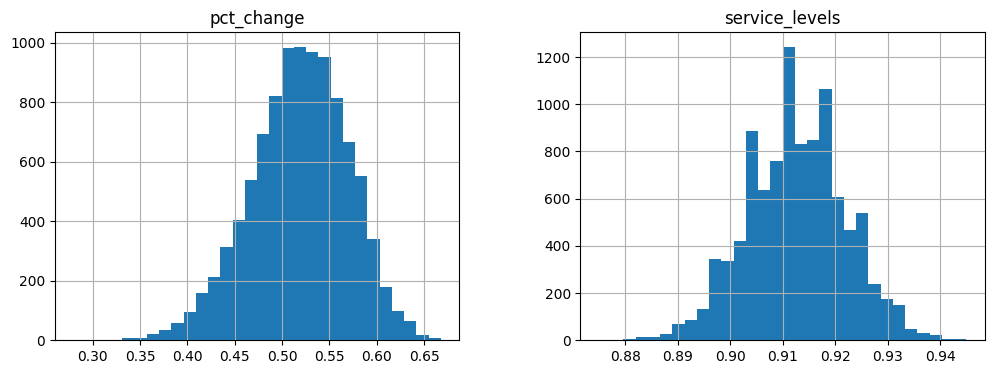

In [153]:
df_min_eoq_sim["pct_change"] = (total_cost_pr - df_min_eoq_sim["costs_suggested"]) / (total_cost_pr)

df_min_eoq_sim[["pct_change", "service_levels"]].hist(figsize=(12, 4), bins=30)
plt.savefig("cost_res_2.png", bbox_inches="tight")
plt.show()

<h4>Comparison of initial and capped Period Review Model</h4>

In [32]:
def q5(x):
    return x.quantile(.05)

def q95(x):
    return x.quantile(.95)

<h4>Results obtained from backtesting strategies on historic data</h4>

In [33]:
df_eoq_hist_res = df_eoq_hist["pct_change"].agg([q5, "median", "mean", q95]).to_frame()
df_min_eoq_hist_res = df_min_eoq_hist["pct_change"].agg([q5, "median", "mean", q95]).to_frame()

df_res_1 = pd.concat([df_eoq_hist_res, df_min_eoq_hist_res], axis=1)
df_res_1.columns = ["pct_change_unconstrained", "pct_change_constrained"]

df_res_1

pct_change_unconstrained  pct_change_constrained
q5                      0.882710                0.776089
median                  0.908371                0.831939
mean                    0.906077                0.829209
q95                     0.921630                0.872804

<h4>Results obtained from sampled data (Simulation)</h4>

In [34]:
df_eoq_sim_res = df_eoq_sim["pct_change"].agg([q5, "median", "mean", q95]).to_frame()
df_min_eoq_sim_res = df_min_eoq_sim["pct_change"].agg([q5, "median", "mean", q95]).to_frame()

df_res_2 = pd.concat([df_eoq_sim_res, df_min_eoq_sim_res], axis=1)
df_res_2.columns = ["pct_change_unconstrained", "pct_change_constrained"]

df_res_2

pct_change_unconstrained  pct_change_constrained
q5                      0.700102                0.429945
median                  0.741904                0.520942
mean                    0.739656                0.518615
q95                     0.770828                0.596971

<h3>Task 4</h3>

<h4>Periodic Review Model with constant Lead Time and random demand</h4>
<br>
$Q^* = \sqrt{\frac{2\bar{D}S}{H}}$ <br>
$T = \frac{Q^*}{\bar{D}}$ <br>
$SS = z_{\alpha} \cdot \sqrt{T^*+LT}$ <br> <br>
$M^* = (T^*+LT) \cdot \bar{D} + SS$

In [35]:
Q = np.sqrt((2*D_mean*S)/ H)
T = Q / D_mean

LT = 15

SS = 1.6449 * D_std * np.sqrt((T + LT))

M = D_mean*(T + LT) + SS

T, M = ceil(T), ceil(M)
T, M

(7, 1176933)

In [140]:
def run_min_eoq_fixed_lt_model(demands: np.array, T: int, M: int, on_hand: int) -> Dict[str, Any]:
    
    n_days = len(demands)
    stock = np.zeros(n_days) # sample demand values for each day from historic distribution
    
    data = {
        "reorders": np.zeros(n_days),
        "n_reorders": 0
    }
    
    stock[0] = on_hand
    
    try_next_day = False
    
    for i in range(n_days-1):
    
        stock[i] -= demands[i]
        # check the inventory after T* days
        if (i % T == 0) or try_next_day:
            
            # if inventory is greater that M dont order anything
            reorder = max(M - stock[i], 0) # reorder the amount necessary to get back to M
            # previously this would trigger the new order but now we have to wait until we have 500000
            if reorder > 0 and reorder < 500000:
                try_next_day = True
                
            if reorder >= 500000:
                try_next_day = False
                data["reorders"][i] = reorder
                data["n_reorders"] += 1

                # increment inventory to the day when resupply arrives
                if (i + LT) <= (n_days - 1):
                    stock[i + LT] += reorder
                     
        stock[i+1] += stock[i]
    
    data["stock"] = stock
    data["demands"] = demands
    
    return data

In [141]:
res = run_min_eoq_fixed_lt_model(
    historic_demands, T=T, M=M, on_hand=stock_state.iloc[0, -1]
)

In [142]:
total_costs: List[float] = []
service_level: List[float] = []

for _ in tqdm(range(10000)):
    
    res = run_min_eoq_fixed_lt_model(
        demands=np.random.normal(D_mean, D_std, 1000), 
        T=T, M=M, 
        on_hand=stock_state.iloc[0, -1]
    )
    
    total_costs.append(calc_total_cost(res))
    service_level.append(
        (res["stock"] > 0).sum() / res["stock"].shape[0] # probability of stockout
    )

df_min_eoq_sim_fixed_lt = pd.DataFrame({
    "costs_suggested": total_costs,
    "service_levels": service_level
})

100%|████████████████████████████████████| 10000/10000 [00:17<00:00, 577.13it/s]


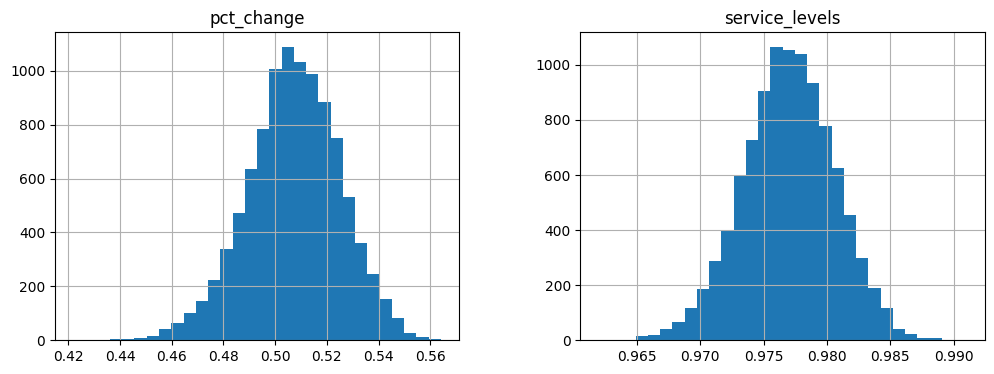

In [155]:
df_min_eoq_sim_fixed_lt["pct_change"] = (
    total_cost_pr - df_min_eoq_sim_fixed_lt["costs_suggested"]
) / (total_cost_pr)

df_min_eoq_sim_fixed_lt[["pct_change", "service_levels"]].hist(figsize=(12, 4), bins=30)

plt.savefig("cost_res_3.png", bbox_inches="tight")
plt.show()

In [161]:
pd.concat([
    df_min_eoq_sim_fixed_lt["pct_change"].describe().to_frame(),
    df_min_eoq_sim["pct_change"].describe().to_frame()
], axis=1).round(3)

pct_change  pct_change
count   10000.000   10000.000
mean        0.507       0.519
std         0.018       0.051
min         0.422       0.280
25%         0.496       0.486
50%         0.507       0.521
75%         0.519       0.555
max         0.564       0.668